##### **Import libraries**

In this fourth post and likely the last post of the logistic regression (LR) series, we're still going to begin with importing all the libraries needed for the following work on model evaluations.

In [1]:
import sklearn
print(f"scikit-learn version used is: {sklearn.__version__}")
from sklearn.model_selection import train_test_split
import polars as pl
print(f"polars version used is: {pl.__version__}")
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
# For model evaluations
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_curve, log_loss

scikit-learn version used is: 1.5.2
polars version used is: 1.6.0


<br>

##### **Import logistic regression pipeline/model**

Next, we need to load the pickled file so we can evaluate the same LR pipeline used last time.

In [2]:
LR = pickle.load(open("LR.pkl", "rb"))
LR

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('LogR',
                 LogisticRegression(random_state=50, solver='liblinear'))])

<br>

##### **Evaluations of the logistic regression model**

This part will involve using accuracy scores, confusion matrix, receiver operating characteristic (ROC) curve, classification report and log loss to evaluate the LR model. The main statistical principles and concepts being referred to here are mostly from this reference textbook [@bruce2020], and a lot of native built-in functions from scikit-learn [@pedregosa2011] are used to generate the results.

###### **Accuracy scores**

The easiest one to understand will be accuracy score, which can be calculated using predicted y outcome and actual or true y outcome in scikit-learn as shown below.

In [3]:
## Read in data & split into training & testing sets
df = pl.read_csv("df_ml.csv")
X = df["#RO5 Violations", "Polar Surface Area", "HBA", "HBD", "QED Weighted", "CX LogP", "CX LogD", "Heavy Atoms"]
y = df["Max_Phase"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)
LR.fit(X_train, y_train)
y_mp = LR.predict(X_test)
accuracy_score(y_mp, y_test)

## getting a warning message after accuracy score generated earlier 
# "UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names" 
# - resolved, missed the fitting step first (my bad) before predict()

0.689594356261023

The accuracy score is 0.69 (after rounding up) which means that there are around 70% of the cases or compounds classified correctly by using the LR classifier. This score is also the same as the one shown from the previous post using `score()` instead of `accuracy_score()`.

Accuracy score gives an idea about how close the predicted samples are to the true values. One caveat to note is that for imbalanced dataset, accuracy score might not be very informative and other evaluation metrics will be needed as well.

<br>

###### **Confusion matrix**

A confusion matrix is built below based on the model in order to visualise the counts of correct and incorrect predictions. Previous code used to plot confusion matrix is shown below:

In [4]:
#| code-fold: true

## Function to print and plot confusion matrix
## The function code below was adapted from the IBM data science course I've taken previously

# # to create iterators for efficient looping
# import itertools
# import numpy as np

# def plot_confusion_matrix(# Sets a cm object (cm = confusion matrix)
#                           cm, 
#                           # Sets classes of '1s' (Successes) & '0s' (Non-successes) for the cm
#                           classes,
#                           # If setting normalize = true, reports in ratios instead of counts
#                           normalize,
#                           title = 'Confusion matrix',
#                           # Choose colour of the cm (using colourmap recognised by matplotlib)
#                           cmap = plt.cm.Reds):
    
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    # # Plot the confusion matrix 
    # plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    # plt.title(title)
    # plt.colorbar()
    # tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, rotation = 45)
    # plt.yticks(tick_marks, classes)

    # # Floats to be round up to two decimal places if using normalize = True
    # # or else use integers
    # fmt = '.2f' if normalize else 'd'
    # # Sets threshold of 0.5
    # thresh = cm.max() / 2.
    # # Iterate through the results and differentiate between two text colours 
    # # by using the threshold as a cut-off
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, format(cm[i, j], fmt),
    #              horizontalalignment = "center",
    #              color = "white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')

# # Compute confusion matrix
# matrix = confusion_matrix(y_test, y_mp, labels = [0,1])
# np.set_printoptions(precision = 2)

# # Plot confusion matrix without normalisation
# plt.figure()
# plot_confusion_matrix(matrix, 
#                       # Define classes of outcomes
#                       classes = ['Max_Phase = 0','Max_Phase = 1'], 
#                       # Set normalize = True if wanting ratios instead
#                       normalize = False, 
#                       title = "Confusion matrix without normalisation"
#                      )

There is actually an alternative and probably a better way (that uses less code) to plot confusion matrix using scikit-learn's code as shown here:

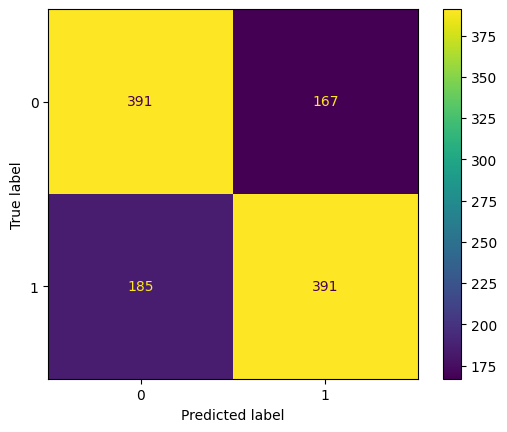

In [5]:
ConfusionMatrixDisplay.from_estimator(LR, X_test, y_test)
plt.show()

A common rule of thumb for confusion matrix is that all predicted outcomes are columns and all the true outcomes are rows. However, there might be exceptions where this would be the other way round. 

Four different categories can be seen in the confusion matrix:

-   True positive - Predicted Max_Phase = 1 & True Max_Phase = 1 (391) - *interested in this*
-   True negative - Predicted Max_Phase = 0 & True Max_Phase = 0 (391)
-   False positive - Predicted Max_Phase = 1 & True Max_Phase = 0 (167)
-   False negative - Predicted Max_Phase = 0 & True Max_Phase = 1 (185)

<br>

###### **Receiver operating characteristic (ROC) curve**

My [old post](https://jhylin.github.io/Data_in_life_blog/posts/17_ML2-2_Random_forest/2_random_forest_classifier.html#brief-introduction) about random forest classifier has already explained what an area under the ROC curve is (I'm just going to quote myself...):

> Area under the ROC curve: [reference](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) - the area under a curve plot between sensitivity or recall (percent of all 1s classified correctly by a classifier or true positive rate) and specificity (percent of all 0s classified correctly by a classifier, or equivalent to 1 - false positive rate or true negative rate) (Bruce, Bruce, and Gedeck 2020). It is useful for evaluating the performance of a classification model via comparing the true positive rate and false positive rate which are influenced by shifting the decision threshold. Area under the ROC is usually represented as a number ranging from 0 to 1 (1 being a perfect classifier, 0.5 or below meaning a poor, ineffective classifier)

In this case, we can also apply ROC curve to the LR model and its predicted outcomes.

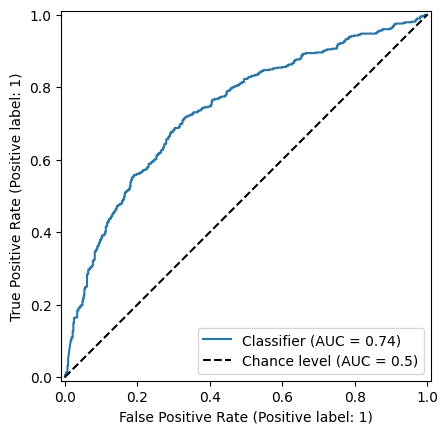

In [6]:
# get the predicted probabilities of outcome = 1 (approved drugs)
y_mp_probs = LR.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_mp_probs, plot_chance_level = True)

<br>

###### **Classification report**

In [7]:
print(classification_report(y_test, y_mp))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       558
           1       0.70      0.68      0.69       576

    accuracy                           0.69      1134
   macro avg       0.69      0.69      0.69      1134
weighted avg       0.69      0.69      0.69      1134



***Precision*** is a measure of the accuracy of a predicted outcome, where a class label has been predicted by the classifier. In this case, we can see that for class label 1, the precision is 0.70, which corresponds to the true positive result of 391 out of 558 samples (= 0.70, for true predicted Max_Phase = 1 column). It is defined by:

$$
\text{Precision} = \frac{\Sigma\ True\ Positive}{(\Sigma\ True\ Positive + \Sigma\ False\ Positive)}
$$

***Recall***, also known as sensitivity (especially widely used in biostatistics and medical diagnostic fields), is a measure of the strength of the classifier to predict a positive outcome. In simple words, it measures the true positive rate. In this example, there is a total of 391 out of 576 samples (which = 0.68, for true Max_Phase = 1 row). It is defined by:

$$
\text{Recall} = \frac{\Sigma\ True\ Positive}{(\Sigma\ True\ Positive + \Sigma\ False\ Negative)}
$$

The precision and recall metrics are also calculated and shown for row 0 in the classification report.

***f1-score***, or also known as balanced F-score or F-measure, denoted the harmonic average of both precision and recall metrics. This metric will also give another indication about whether this model performed well on outcome predictions. Its range is normally from 0 (worst precision and recall) to 1 (perfect precision and recall). For this particular classifier, f1-score was at 0.69 (for class label = 1). It is defined as:

$$
\text{F1-score} = \frac{2 \times (Precision \times Recall)}{(Precision + Recall)}
$$

***Support*** is the total number of true samples in each class label (reading row-wise from the confusion matrix). The main purpose of showing this metric is to help clarifying whether the model has had a reasonably balanced dataset for each class (and also helped to check the precision and recall values if needed).

<br>

###### **Log loss**

Log loss can be used as another metric to show how good the classifier is at making the predictions. The further apart the predicted probability is from the true value, the larger the log loss, which is also ranging from 0 to 1. Ideally, the smaller the log loss the better the model will be. Here, we have a log loss of 0.61 (after rounding up) for this particular model.

In [8]:
log_loss(y_test, y_mp_probs)

0.6097696128595831

<br>

#### **Thoughts**

So here I've completed a very basic LR classifier model for ChEMBL small molecules dataset. This is certainly not the most optimal machine learning model as I've only wanted to show how a baseline LR model can be built. This post update has added a molecular features versus coefficients plot (in the previous post) which shows the different weightings of the features used to train the dataset, ideally I should include more to provide a better overview of how the physicochemical properties will influence the prediction outcomes, but potentially this plot sort of answers the main goal of the post - which molecular properties might influence max phase outcomes. This last post here is really to show all the different evaluation metrics for the LR model, and I've added a ROC curve this time.

To further improve this model, I could possibly try hyperparameter tuning although I've come across comments from others in the past that it might not improve LR model that much once it's done. Originally I do have two other posts following on from the first one (which is currently splitted into four smaller posts), and one of them is about hyperparameter tuning. My possible plan at the moment is to maybe update these other two posts further down the line and I may decide to condense or remove them if it's not really going to make much difference or impact, I'll see...

<br>

#### **Acknowledgements**

Huge thanks to our online open-source communities, libraries, and also all the references used in this series of posts.

<br>

#### **Online references**

I've listed below all the online references used throughout this project. All the other journal paper or text book references used should be cited in the post already and listed below. 

-   [scikit-learn documentation](https://scikit-learn.org/stable/index.html)
-   [Stack Overflow](https://stackoverflow.com)
-   Polars references:
    1.  [Polars - User Guide](https://pola-rs.github.io/polars-book/user-guide/introduction.html) - https://pola-rs.github.io/polars-book/user-guide/introduction.html
    2.  [Polars documentation](https://pola-rs.github.io/polars/py-polars/html/index.html#) - https://pola-rs.github.io/polars/py-polars/html/index.html#
    3.  [Polars GitHub repository](https://github.com/pola-rs/polars) - https://github.com/pola-rs/polars